## Convection model with solidus

This notebook implements a thermal convection model with temperature dependent viscosity.

$$
    \nabla \cdot \left( \eta \nabla \dot\varepsilon \right) - \nabla p = 
     \mathrm{Ra}  T \mathbf{\hat z}
$$

$$
    \nabla \cdot \mathbf{v} = 0
$$

The thermal evolution is controlled by advection and  diffusion:

$$
    \frac{D T}{D t} = \nabla^2 T 
$$    

The viscosity is defined by 

$$
    \eta = \eta_0 \exp\left( \frac{E}{T+1} \right)
$$

$\mathrm{Ra}$ is the Rayleigh number is defined by

$$ 
    \mathrm{Ra} = \frac{g \rho \alpha \Delta T h ^3}{\kappa \eta _0} ; 
$$

An initial temperature distribution is required. It could be read in from a previous calculation but here we use a perturbed linear temperature gradient.

$$
    T = (1 - y) + 0.1 \cdot \left( \sin(\pi y) + \cos(\pi x) \right)
$$

We compare the temperature at each point with a simple solidus defined as a linear function with depth 
and capped below a certain depth. The excess temperature could be used as the start of a very simple
instantaneous and history-independent melting model such as that of Watson & McKenzie (1991).

We can also see how the melting at depth can be mapped to the surface and tracked on particles through time.


Watson, S., McKenzie, D., Melt Generation by Plumes: A Study of Hawaiian Volcanism
J. Petrology (1991) 32 (3): 501-537 doi:10.1093/petrology/32.3.501


In [1]:
# Convection model that uses functions to determine where the temperature 
# lies above a simple solidus (linear with depth, then capped) 

# Also shows how to map the melt production values on a swarm to the surface (but not how to 
# create an integral of the values ... 

# TODO: show how we can track the melt history over time 1) for a particle and 2) for a particle at the surface
# recording melt distribution (will also be useful for subduction to track the arc)

%matplotlib inline

import underworld as uw
import math
from underworld import function as fn
import glucifer.pylab as plt

In [2]:
dim = 2

In [3]:
# create mesh objects (make alternates - either Q2dP1 or Q1dP0 which can be used for computation. The discontinuous
# submeshes can also be retrieved)

Q2dQ1Mesh = uw.mesh.FeMesh_Cartesian( elementType='Q2/dPc1', 
                                      elementRes=(64,16), 
                                      minCoord=(0.,0.), 
                                      maxCoord=(4.,1.)  )

Q2Mesh   = Q2dQ1Mesh # the default action is to behave as the master mesh
dQ1Mesh  = Q2dQ1Mesh.subMesh 

Q1dP0Mesh = uw.mesh.FeMesh_Cartesian( elementType='Q1/dQ0',
                                         elementRes=(128,32), 
                                           minCoord=(0.,0.), 
                                           maxCoord=(4.,1.)  )

Q1Mesh =  Q1dP0Mesh
dP0Mesh = Q1dP0Mesh.subMesh

velocityMesh =  Q2Mesh
pressureMesh = dQ1Mesh


In [4]:
# create meshvariables
velocityField    = uw.mesh.MeshVariable( mesh=velocityMesh,   nodeDofCount=dim )
pressureField    = uw.mesh.MeshVariable( mesh=pressureMesh,   nodeDofCount=1 )
temperatureField = uw.mesh.MeshVariable( mesh=velocityMesh,   nodeDofCount=1 )

In [5]:
# Initialise data.. Note that we are also setting boundary conditions here

velocityField.data[:] = [0.,0.]
pressureField.data[:] = 0.
temperatureField.data[:] = 0.

# Setup temperature initial condition via underlying data viewed as numpy arrays

toptemp = 0.
bottomtemp = 1.
scaleFactor = bottomtemp - toptemp
import math
tempData = temperatureField.data
perturbation_scale = 0.1
for index, coord in enumerate(velocityMesh.data):
    pertCoeff = math.cos( math.pi * coord[0] ) * math.sin( math.pi * coord[1] )
    tempData[index] = min(1,max(0,toptemp + scaleFactor*(1. - coord[1]) + perturbation_scale * pertCoeff ));

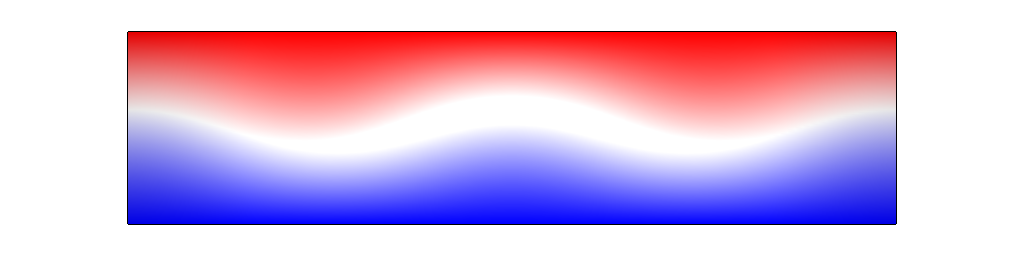

In [6]:
figtemp = plt.Figure(figsize=(1024,256))
tempminmax = fn.view.min_max(temperatureField)
figtemp.Surface(tempminmax, velocityMesh, colours=["red", "white", "blue"], colourBar=False)
figtemp.show()

In [7]:
# Get list of special sets.
# These are sets of vertices on the mesh. In this case we want to set them as boundary conditions.
velocityMesh.specialSets.keys()

['MaxI_VertexSet',
 'MinI_VertexSet',
 'AllWalls',
 'MinJ_VertexSet',
 'MaxJ_VertexSet',
 'Empty']

In [8]:
# Get the actual sets 
#
#  HJJJJJJH
#  I      I
#  I      I
#  I      I
#  HJJJJJJH
#  
#  Note that H = I & J 

# Note that we use operator overloading to combine sets
IWalls = velocityMesh.specialSets["MinI_VertexSet"] + velocityMesh.specialSets["MaxI_VertexSet"]
JWalls = velocityMesh.specialSets["MinJ_VertexSet"] + velocityMesh.specialSets["MaxJ_VertexSet"]

In [9]:
# Now setup the dirichlet boundary condition
# Note that through this object, we are flagging to the system 
# that these nodes are to be considered as boundary conditions. 
# Also note that we provide a tuple of sets.. One for the Vx, one for Vy.
freeslipBC = uw.conditions.DirichletCondition(    variable=velocityField, 
                                                  indexSetsPerDof=(IWalls,JWalls) )

# also set dirichlet for temp field
tempBC = uw.conditions.DirichletCondition(    variable=temperatureField, 
                                              indexSetsPerDof=(JWalls,) )

In [10]:
# lets ensure temp boundaries are still what we want as the IC above might have set slightly different values
# on the boundaries

for index in velocityMesh.specialSets["MinJ_VertexSet"]:
    temperatureField.data[index] = 1.
for index in velocityMesh.specialSets["MaxJ_VertexSet"]:
    temperatureField.data[index] = 0

In [11]:
# We create swarms of particles which can advect, and which we can use to track history
gSwarm = uw.swarm.Swarm( mesh=velocityMesh )

# Now we add a data variable which will store an index to determine material
materialVariable = gSwarm.add_variable( dataType="float", count=1 )
spareVariable    = gSwarm.add_variable( dataType="float", count=1 )

# Layouts are used to populate the swarm across the whole domain
# Create the layout object
layout = uw.swarm.layouts.GlobalSpaceFillerLayout( swarm=gSwarm, particlesPerCell=13 )
# Now use it to populate.
gSwarm.populate_using_layout( layout=layout )

In [12]:
import numpy

materialVariable.data[:] = 100.0

xCoord = numpy.sign(numpy.mod(gSwarm.particleCoordinates.data.T[0],0.25) - 0.125).reshape(-1,1)
yCoord = numpy.sign(numpy.mod(gSwarm.particleCoordinates.data.T[1],0.25) - 0.125).reshape(-1,1)

materialVariable.data[:] = xCoord[:] * yCoord[:] 

mVmin = materialVariable.data.min()
mVmax = materialVariable.data.max()

materialVariable.data[:] =  (materialVariable.data[:] - mVmin) / (mVmax-mVmin)
spareVariable.data[:]    =  1.0 + (materialVariable.data[:] - mVmin) / (mVmax-mVmin)


In [13]:
# Rheology

eta0 = 1.0e-3
activationEnergy = 2.0 * math.log(1/eta0)
Ra = 1.e6
fn_viscosity = eta0 *  fn.math.exp( activationEnergy / (fn.misc.max(0.0,fn.misc.min(1.0,temperatureField))+1.) ) 

densityFn = Ra*temperatureField
# Define our gravity using a python tuple (this will be automatically converted to a function)
gravity = ( 0.0, 1.0 )
# now create a buoyancy force vector.. the gravity tuple is converted to a function 
# here via operator overloading
buoyancyFn = gravity*densityFn

print "Delta eta = ", fn_viscosity.evaluate((0.0,1.0)) / fn_viscosity.evaluate((0.0,0.0)) 


Delta eta =  [[1000.]]


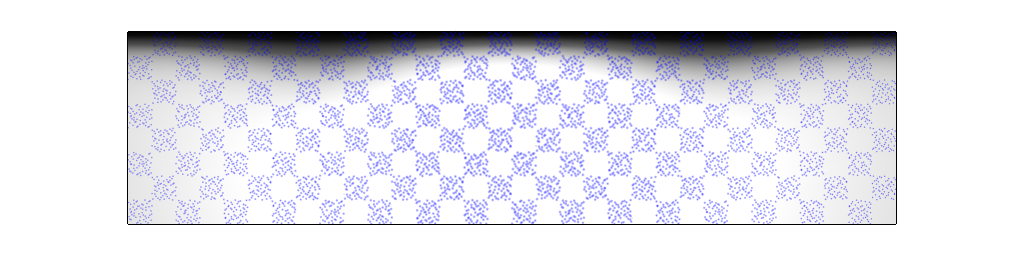

In [14]:
# lets take a look at the eta function

figEta = plt.Figure(figsize=(1024,256))
figEta.Surface(fn_viscosity, velocityMesh, colours=["#FFFFFF","#555555", "#111111", '#000000'], colourBar=False)
figEta.Points(gSwarm, colours=["darkred", "blue"], pointSize=3.0, sizeVariable=materialVariable, colourVariable=materialVariable, opacity=0.5, colourBar=False)
figEta.show()

In [15]:
# Setup a stokes system
# For PIC style integration, we include a swarm for the a PIC integration swarm is generated within.
# For gauss integration, simple do not include the swarm. Nearest neighbour is used where required.
stokesPIC = uw.systems.Stokes(velocityField=velocityField, 
                              pressureField=pressureField,
                              conditions=[freeslipBC,],
                              fn_viscosity=fn.exception.SafeMaths(fn_viscosity), 
                              fn_bodyforce=buoyancyFn )

solver=uw.systems.Solver(stokesPIC)

solver.options.main.Q22_pc_type='uw'  # also try 'gtkg', 'gkgdiag' and 'uwscale'
solver.options.main.penalty = 1.0
solver.options.A11.ksp_rtol=1e-4
solver.options.scr.ksp_rtol=1e-3
solver.options.scr.use_previous_guess = True
solver.options.scr.ksp_set_min_it_converge = 1
solver.options.scr.ksp_set_max_it = 100
solver.options.mg.levels = 5
solver.options.mg.mg_levels_ksp_type = 'chebyshev'
solver.options.mg_accel.mg_accelerating_smoothing = True
solver.options.mg_accel.mg_accelerating_smoothing_view = False
solver.options.mg_accel.mg_smooths_to_start = 1

# Load this solver onto the equation system (displacing the default)
stokesPIC.solve = solver.solve


In [16]:
# Create advdiff system
advDiff = uw.systems.AdvectionDiffusion( temperatureField, velocityField, diffusivity=1., conditions=[tempBC,] )

# And the particle updating system
advector = uw.systems.SwarmAdvector( swarm=gSwarm, velocityField=velocityField, order=2 )

# Also create some integral objects which are used to calculate statistics
v2sum_integral  = uw.utils.Integral( mesh=velocityMesh, fn=fn.math.dot(velocityField, velocityField) ) 
volume_integral = uw.utils.Integral( mesh=velocityMesh, fn=1. )

In [17]:
def nusselt(temp_field, mesh):

    surface_Tgradient = -temp_field.gradientFn.evaluate(velocityMesh.specialSets["MaxJ_VertexSet"]).T[1]
    basalT = temp_field.evaluate(velocityMesh.specialSets["MinJ_VertexSet"])
    
    nusselt = surface_Tgradient.mean() / basalT.mean()

    return nusselt

In [18]:
# Stepping. Initialise time and timestep.
realtime = 0.
step = 0
time_vals = []
vrms_vals = []
Nu_vals = []

In [19]:
import time

start = time.clock()
# Perform 1000 or so steps

volume = volume_integral.integrate()
while step<500:
    # Get solution for initial configuration
    stokesPIC.solve()
    # Retrieve the maximum possible timestep for the AD system.
    dt = advDiff.get_max_dt()
    if step == 0:
        dt = 0.
    # Advect using this timestep siz    
    advDiff.integrate(dt)
    advector.integrate(dt)
    # Calculate the RMS velocity
    v2sum = v2sum_integral.integrate()
    rms_v = math.sqrt(v2sum[0]/volume[0])
    nu_no = nusselt(temperatureField, velocityMesh)
    
    # Increment time and store results
    realtime += dt
    step += 1
    vrms_vals.append( rms_v )
    time_vals.append( realtime )
    Nu_vals.append(nu_no)
                   
    if step == 0 or step % 25 == 0:
        print "step = {:04d}; time = {:.6f}, vrms = {:6.2f}, nusselt = {:6.4f}, CPU = {:4.1f}s".format(
               step, realtime, rms_v, nu_no, time.clock()-start)
        # Animation frame
        
        figVT = plt.Figure()
        figVT = plt.Figure(figsize=(1024,512))
        figVT.Surface(temperatureField, velocityMesh, colours=["#333333","#666666", "#999999", '#FFFFFFF'])
        figVT.Points(gSwarm, colours=["red", "blue"], colourBar=False, pointSize=4.0, colourVariable=materialVariable, opacity=0.5)
        figVT.VectorArrows(velocityField, velocityMesh, lengthScale=0.1/rms_v, arrowHeadSize=0.15 )        
        figVT.save_image("TEST/Temperature+Markers.{:04d}".format(step))
        del figVT 
        
        

step = 0025; time = 0.000506, vrms = 162.51, nusselt = 1.0103, CPU =  8.0s


IOError: [Errno 2] No such file or directory: '/Users/jmansour/work/code/underworld2/UserGuide/TEST/Temperature+Markers.0025.png'

In [ ]:
print "average time per timestep = ", (time.clock() - start)/float(step), " over ", step, " steps"

In [ ]:
import matplotlib.pyplot as pyplot
#import numpy as np

surface_points_X = velocityMesh.data[velocityMesh.specialSets["MinJ_VertexSet"].data].T[0]

figure, (plot1, plot2) = pyplot.subplots(1,2)
figure.set_size_inches(10,6)
plot1.plot(time_vals, vrms_vals, linewidth=2.5)
plot2.plot(time_vals, Nu_vals, linewidth=2.5)

figure.show()

In [ ]:
figVT = plt.Figure(figsize=(1024,384))
figVT.Surface(temperatureField, velocityMesh, colours=["#333333","#666666", "#999999", '#FFFFFFF'])
figVT.Points(gSwarm, colours=["darkred", "white"], colourBar=True, pointSize=4.0, colourVariable=materialVariable, opacity=0.25)
figVT.VectorArrows(velocityField, velocityMesh, lengthScale=0.1/rms_v, arrowHeadSize=0.15 )
figVT.show()

In [ ]:
# Definition of a linear solidus (with cutoff) using underworld functions

T0 = 0.7
D0 = 1.0
Tex = 0.85
Dex = 0.5

yCoordFn = fn.input()[1]
solidusFn = T0 - ((T0 - Tex) / (D0 - Dex)) * (D0 - yCoordFn)
excessTempFn = fn.misc.max(0.0, temperatureField - solidusFn)

ET2 = excessTempFn.evaluate(gSwarm)


In [ ]:
spareVariable.data[:] = ET2[:]

limTempFn = fn.misc.min(fn.misc.max(temperatureField, 0.0),1.0)


figVT = plt.Figure(figsize=(1024,256))
figVT.Surface(limTempFn, velocityMesh, colours=["#00000","#444444", "#999999", '#FFFFFFF'])
figVT.Points(gSwarm, colours=["white", "red", "yellow"], colourBar=True, pointSize=100.0, 
             colourVariable=spareVariable, sizeVariable=spareVariable)
figVT.VectorArrows(velocityField, velocityMesh, lengthScale=0.1/rms_v, arrowHeadSize=0.15 )
figVT.show()

In [ ]:
## map the melt production rate (currently excess temperature) to the surface
## in parallel this requires us to communicate the information to processes which
## own the surface. One way to do this for swarm data is to teleport the whole lot to y=1.0

# An improvement would be to only make a swarm with the particles having non-zero melt
# and then flatten this to the surface

melting_particles = numpy.where(spareVariable.data > 0.0)[0]

spareSwarm = uw.swarm.Swarm( mesh=Q1Mesh )
spareSwarm.add_particles_with_coordinates(gSwarm.particleCoordinates.data[melting_particles])
newVar         = spareSwarm.add_variable(dataType="float", count=1)
newVar.data[:] = spareVariable.data[melting_particles]

# Flatten swarm to surface
spareSwarm.particleCoordinates.data[:,1] = 1.0
spareSwarm.update_particle_owners()


In [ ]:
ExcessTField = uw.mesh.MeshVariable( mesh=dP0Mesh, nodeDofCount=1 )
ExcessTField.data[:] = 0.0

In [ ]:
for point, value in enumerate(newVar.data):
#    print point, value
    cell = spareSwarm.owningCell.data[point]
    ExcessTField.data[ cell ] += value
    
print numpy.count_nonzero(ExcessTField.data)

In [ ]:
figVT = plt.Figure(figsize=(1024,256))
figVT.Surface(ExcessTField, Q1Mesh, colours=["#00000","red", "orange", 'yellow'])
figVT.Points(gSwarm, colours=["white", "red", "yellow"], colourBar=True, pointSize=100.0, 
             colourVariable=spareVariable, sizeVariable=spareVariable)
figVT.show()

In [ ]:
surfacePoints = velocityMesh.data[velocityMesh.specialSets["MaxJ_VertexSet"].data]
surfaceExcessT = ExcessTField.evaluate(surfacePoints)

figure, (plot1) = pyplot.subplots(1,1)
figure.set_size_inches(12,3)
plot1.scatter(surfacePoints.T[0], surfaceExcessT, marker="x")
plot1.set_xlim(0,4)

figure.show()



In [ ]:
## What does the stress look like ?



